## Contraction dynamics demo
The contractile dynamics portion of this model needs three inputs: a neural input $u(t) \in [0,1]$, an activation value $a(t) \in [0,1]$ and a muscle fiber length $l^M(t)$ at a given time $t$.  The model will then give us the entire actuator's force $F^{MT}(t)$ and, at the next timestep $t + \Delta t$, fiber contraction velocity $\dot{l}^M(t + \Delta t)$.  With fiber velocity $\dot{l}^M(t + \Delta t)$ and the current fiber length $l^M(t)$, we can figure out the next fiber-length $l^M(t + \Delta t)$ for the next iteration of the simulation.  Please refer to the links in the readme file under 'helpful resources' for more information.

The muscle model consists of two main parts:  the muscle fibers and tendon.  The muscle fibers themselves have two avenues of force production:  first, the passive elements of muscle have stiffness and produce force when stretched; second, the contractile element produces force from actin-myosin interactions stimulated by activation.

fyi, the activation demo is fully built out, whereas this demo still has a few bugs.  I belive that my error is coming from update muscle and tendon length.

In the update of muscle length $l^M$ , I use the following logic: $l^M_{n+1} = l^M_n + v * dt$ where $l^M_{n+1}$ and $l^M_n$ are muscle lengths at times $n+1$ and $n$, and $v$ and $dt$ are the muscle's contraction rate and timestep.  This gives me the new muscle length $l^M_{n+1}$.

To find the new tendon length, I use the logic $l^T_{n+1} = l^T_{n} * ( 1 - strain )$ where $l^T_{n+1}$ and $l^T_{n}$ are tendon lengths at times $n+1$ and $n$, and $strain$ is the tendon strain.  This gives me the new tendon length $l^T_{n+1}$.

Then, I update the total length of the actuator with $l^{MT}_{n+1} = l^M_{n+1} + l^T_{n+1}$.  I have a suspicion that one of these three calls is the bug, however, I do not know how else to update lengths at this moment.

To begin, let's import the necessary libraries

In [282]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import random

Below is a class called Contraction.  Contraction takes three inputs:  an activation value, a current fiber length value and the total length of the muscle-tendon unit.  Methods marked with an underscore are internal methods.  To get the fiber velocity or muscle-tendon actuator force, call the last two functions in this class.

In [283]:
class Contraction:
    """
    equations describing muscle contraction dynamics, length and forces
    inputs are activation (real number between 0 and 1) and muscle fiber length lM
    outputs are muscle-tendon actuator force (fMT), d/dt of activation for next timestep (a_dot)
    and d/dt of fiber length (l_dot)

    Parameters
    
        VARYING PARAMETERS
        
        FM_o    (float):   maximum isometric force of muscle
        lM_o    (float):   optimal fiber length of muscle
        lT_s    (float):   tendon slack length (tendon length below which tendon produces no force)
        alpha_o (float):   pennation angle of the muscle fibers at optimal fiber length
        
        CONSTANT PARAMETERS
        eM_o    (float):   passive muscle strain due to maximum isometric force
        k_toe   (float):   exp shape factor
        eT_o    (float):   tendon strain due to maximum isometric force
        k_lin   (float):   linear shape factor
        eT_toe  (float):   tendon strain above which tendon force is linear w.r.t. tendon strain
        FT_toe  (float):   normalized tendon force above which tendon force is linear w.r.t. tendon strain
        kPE     (float):   exp shape factor for passive FL relationship
        gamma   (float):   shape factor for gaussian active FL relationship
        Af      (float):   FV shape factor 
        FM_len  (float):   max normalized muscle force when fiber is lengthening
        w       (float):   constant muscle width
        chi     (float):   passive damping factor
    """
    def __init__(self, activation, lM, lMT, FM_o = 3, lM_o = 0.3, lT_s = 0.5, alpha_o = 0):
        # muscle model inputs
        self.activation = activation
        self.lM = lM
        self.lMT = lMT
        
        # constants that may vary between muscle
        self.FM_o = FM_o
        self.lM_o = lM_o
        self.lT_s = lT_s
        self.alpha_o = alpha_o
        
        # constants that do not vary between muscle
        self.eM_o = 0.6
        self.k_toe = 3.0
        self.eT_o = 0.033
        self.k_lin = 1.712 / self.eT_o
        self.eT_toe = 0.609 * self.eT_o
        self.FT_toe = 1/3
        self.kPE = 4.0
        self.gamma = 0.5
        self.Af = 0.3
        self.FM_len = 1.8
        self.w = self.lM_o * np.sin(self.alpha_o)
        self.chi = 0.05
        self.e = 10**-6
        self.a = 0.5
    
    def _pennation(self,):
        '''calculate pennation angle'''
        x = self.w / self.lM
        if self.lM == 0 or x <= 0:
            alpha = 0
        elif 0 < x and x < 1:
            alpha = np.arcsin(self.w / self.lM)
        elif 1 <= x:
            alpha = np.pi / 2
        return alpha
    
    def _active_force(self,):
        '''calculate active muscle force'''
        fl_bar = np.exp(- ( self.lM / self.lM_o - 1 )**2 / self.gamma )
        return self.activation * self.FM_o * fl_bar
    
    def _passive_force(self,):
        '''calculate active muscle force'''
        lM_bar = self.lM / self.lM_o
        if lM_bar > 1 + self.eM_o:
            FPE_bar = 1 + self.kPE / self.eM_o * ( lM_bar - ( 1 + self.eM_o ) )
        elif lM_bar <= (1 + self.eM_o):
            FPE_bar = np.exp( self.kPE * (lM_bar - 1) / self.eM_o ) / np.exp( self.kPE )
        return self.FM_o * FPE_bar
    
    def _tendon_length(self,):
        ''' calculate tendon length '''
        alpha = self._pennation()
        return self.lMT - self.lM * np.cos(alpha)
        
    def _tendon_strain(self,):
        ''' calculate tendon strain '''
        norm_slack = self.lT_s / self.lM_o
        norm_tendon = self._tendon_length() / self.lM_o
        return (norm_tendon - norm_slack) / norm_slack
    
    def _tendon_force(self,):
        ''' calculate tendon force '''
        eT = self._tendon_strain()
        if eT > self.eT_toe:
            FT_bar = self.k_lin * (eT - self.eT_toe) + self.FT_toe
        elif 0 < eT and eT <= self.eT_toe:
            FT_bar = self.FT_toe * ( np.exp(self.k_toe * eT / self.eT_toe) - 1 ) / ( np.exp(self.k_toe) - 1 )
        else:
            FT_bar = 0
        return self.FM_o * 0.001 * ( 1 + eT ) * FT_bar
    
    def _contractile_force(self,):
        '''calculate contractile muscle force'''
        FT = self._tendon_force()
        alpha = self._pennation()
        FPE = self._passive_force()
        return FT / np.cos(alpha) - FPE
    
    def _inv_FV(self,):
        Fa = self._active_force()
        Fce = self._contractile_force()
        
        num = 0.95 * self.FM_len * Fa - Fa
        denom = ( (2 + 2/self.Af) * 0.05 * Fa * self.FM_len ) / (self.FM_len - 1) + self.chi
        f_vo = num / denom
        
        num1 = (0.95 + self.e) * self.FM_len * Fa - Fa
        denom1 = ( (2 + 2/self.Af) * ( 0.05 - self.e ) * Fa * self.FM_len ) / (self.FM_len - 1) + self.chi
        f_v1 = num1 / denom1
        
        if Fce < 0:
            fv_inv = Fce / self.e * ( (self.e - Fa) / (Fa + self.e / self.Af + self.chi) + Fa / (Fa + self.chi) ) - Fa / (Fa + self.chi)
        elif 0 <= Fce and Fce < Fa:
            fv_inv = (Fce - Fa) / (Fa + Fce / self.Af + self.chi)
        elif Fa <= Fce and Fce < 0.95*Fa*self.FM_len:
            fv_inv = (Fce - Fa) / ( ( (2 + 2/self.Af) * (Fa * self.FM_len - Fce) ) / (self.FM_len - 1) + self.chi )
        elif 0.95*Fa*self.FM_len <= Fce:
            fv_inv = f_vo + (Fce - 0.95*Fa*self.FM_len) / (self.e*Fa*self.FM_len) * (f_v1 - f_vo)
        
        return fv_inv
    
    def fiber_velocity(self,):
        l_dot_bar = self._inv_FV()
        Vmax = (5 + 5 * self.activation) * self.lM_o
        return l_dot_bar# * Vmax
    
    def mt_force(self,):
        return self._tendon_force()

Below the tendon slack length $l^T_s$ the tendon (and therefore the whole muscle) produces zero force.  To illustrate this point, let's feed to the model full activation $a(t) = 1.0$, a fiber length at its optimal value $l^M_o = l^M = 0.3$, but a tendon length less than the tendon slack length $l^T = 0.45 < 0.5 = l^T_s$.

In [284]:
activation = 1.0
lM = 0.3
lT = 0.45

lMT = lM + lT
muscle = Contraction(activation, lM, lMT)

contractile = muscle._contractile_force()
active = muscle._active_force()
print('contractile force = ' + str(contractile))
print('passive force = ' + str(passive))

print('actuator force = ' + str(muscle.mt_force()))

contractile force = -0.05494691666620255
passive force = 0.05494691666620255
actuator force = 0.0


Zero force as expected -- at lengths below the slack length, the contractile and passive forces cancel.  If, however, the tendon length is greater than the tendon slack length, then we can get contraction.  Let's feed to the model different activations $a(t) \in [0,1.0]$, a fiber length at its optimal value $l^M_o = l^M = 0.3$, and a tendon length greater than the tendon slack length $l^T = 0.55 > 0.5 = l^T_s$.

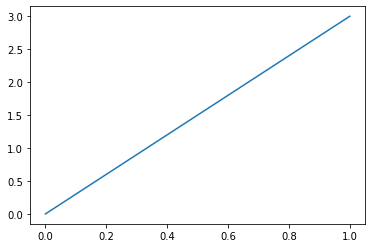

In [285]:
lM = 0.3
lT = 0.55
lMT = lM + lT

activation = np.linspace(0,1)
forces = []

for i in activation:
    muscle = Contraction(i, lM, lMT)
    a = muscle._active_force()    
    forces.append(a)
    
plt.plot(activation, forces)

As we increase the activation within the muscle, we see a linear increase in active forces are generated.  As we increase activation, more calcium ions are in the area and can faciliate more actin-myosin cross bridges to form.

Let's step through a couple iterations of contraction. To do so, we'll initialize as before with $a(t) = 0.5$, our initial length $l^M = 0.3$ and tendon length $l^T = 0.55$.

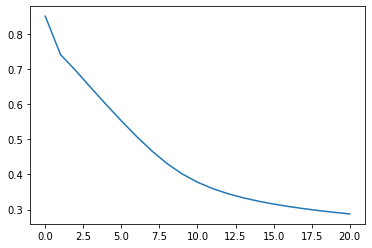

In [286]:
num = 20

activation = 0.5
lM = 0.3
lT = 0.55
lMT = lM + lT

model = Contraction(activation, lM, lMT)

length = [lMT]

for t in np.linspace(0,1,num):
    
    v = model.fiber_velocity()
    lM = lM + v/num
    
    lT = model._tendon_length() * ( 1 - model._tendon_strain() )
    lMT = lM + lT
    
    length.append(lMT)
    
    model.lM = lM
    model.lMT = lMT

plt.plot(length)
plt.show()

above we show the muscle-tendon unit's length throughout time.  You can see that during contraction (as we have a nonzero $a(t)$) that the length of the actuator decreases because tension is generated.

At each time step, I calculate the muscle fiber's contraction velocity v -- I can then update the total length of *only* the muscle.  I then access the tendon's length and strain -- knowing its current length and strain, I can work backwards to update *only* the tendon's new length.  With a new muscle and new tendon length, I can update the length of the entire actuator and write these new values to the model.

let's look at the same now tracking how length, velocity, force, and strain change throughout time.

In [291]:
num = 20
dt = 0.01

activation = 0.5
lM = 0.45
lT = 0.55
lMT = lM + lT

model = Contraction(activation, lM, lMT)

length = [lM]
force = [model.mt_force()]
velo = [model.fiber_velocity()]
strain = [model._tendon_strain()]

for t in np.linspace(0,1,num):
        
    f = model.mt_force()
    force.append(f)
    
    v = model.fiber_velocity()
    velo.append(v)
    
    lM = lM + v * dt
    length.append(lM)
    
    s = model._tendon_strain()
    strain.append(s)
    lT = model._tendon_length() * ( 1 - s )
    
    lMT = lM + lT
    
    model.lM = lM
    model.lMT = lMT

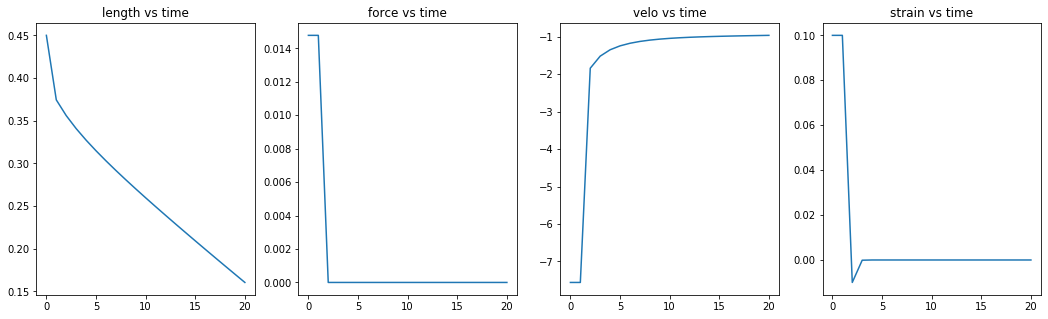

In [292]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_figheight(5)
fig.set_figwidth(18)
ax1.plot(length)
ax1.title.set_text('length vs time')
ax2.plot(force)
ax2.title.set_text('force vs time')
ax3.plot(velo)
ax3.title.set_text('velo vs time')
ax4.plot(strain)
ax4.title.set_text('strain vs time')
plt.show()

So, we see that over time length decreases at a decreasing rate.  Looking at the velo vs time plot, this makes sense.  We first start off with a high contraction velocity which then slows down over time (leading to the decreasing rate of length change).

The force function, however, looks like a step function.  We initially have a contratile force, however, this shuts off once the tendon reaches the tendon slack length.

Lastly, strain as a function of time looks like the tendon initially oscillates around zero strain before 'damping out' and finding equalibrium at strain = 0.

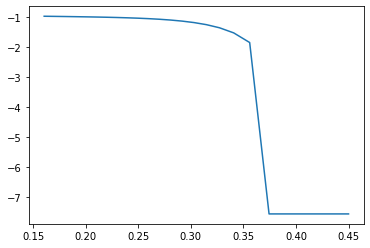

In [293]:
plt.plot(length,velo)

plotting velo vs length above, we see that at longer lengths of the contractile element, we get quicker rate of contration.

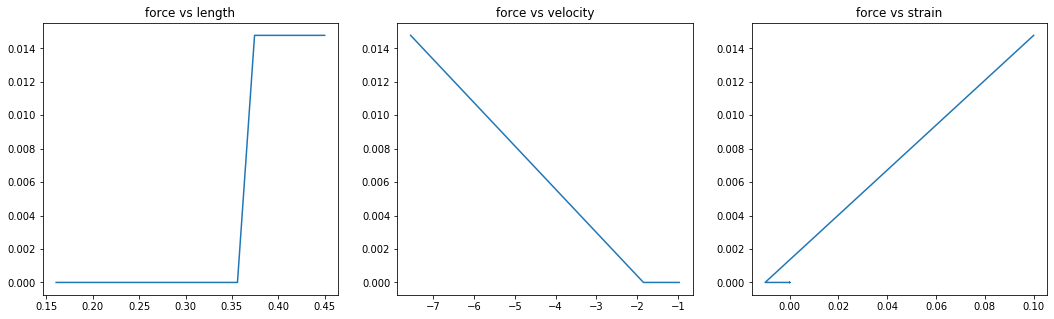

In [294]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(18)
ax1.plot(length, force)
ax1.title.set_text('force vs length')
ax2.plot(velo, force)
ax2.title.set_text('force vs velocity')
ax3.plot(strain, force)
ax3.title.set_text('force vs strain')
plt.show()

Looking at the readme of this repo, you'll see three intrinsic properties of muscle that we are trying to model: force-length, force-velocity, and force-strain.  We did not exactly match what we are looking for, however, the trends look similar at least.

For the force-length curve, we see very little force at short lengths (which is expected of muscle's FL relationship).  Then when we reach the optimal fiber length (around $l^M = 0.3$), we hit a maximum in force generated (which is also predicted by the model).  As length increases further, we should see the passive elements of muscle take over and force should grow exponentially; this trend, however, is not present in our data for some reason.

Looking at the force-velocity (FV) curve, the opposite of what I expect is present.  The FV curve says that as the rate of muscle shortening increases (more negative v), then the force of the actuator decreases.  The reasoning behind this is because as contraction rate increases, less actin-myosin cross bridges can form as the muscle is sliding quickly, and thus the force decreases.  This incorrect FV relationship may hold a clue to where the current bug is.

Lastly, we see the tendon's force-strain curve.  Again, the trend here matches (not exactly, but it matches) what the muscle's properties predict.  As strain in the tendon increases, so does the actuator's force.  I would expect this graph to have more curvature, however.